In [ ]:
import math
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tqdm.notebook import tqdm
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import numpy.random as npr
import os, time, gc, random
import glob
import PIL
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


Layer

In [ ]:
# blocks used in GAN

def minibatchStd(inputs):
    inputs = tf.transpose(inputs, (0, 3, 1, 2)) # NHWC -> NCHW
    group_size = tf.minimum(4, tf.shape(inputs)[0])             # Minibatch must be divisible by (or smaller than) group_size.
    s = inputs.shape                                             # [NCHW]  Input shape.
    y = tf.reshape(inputs, [group_size, -1, 1, s[1], s[2], s[3]])   # [GMncHW] Split minibatch into M groups of size G. Split channels into n channel groups c.
    y -= tf.reduce_mean(y, axis=0, keepdims=True)           # [GMncHW] Subtract mean over group.
    y = tf.reduce_mean(tf.square(y), axis=0)                # [MncHW]  Calc variance over group.
    y = tf.sqrt(y + eps)                                    # [MncHW]  Calc stddev over group.
    y = tf.reduce_mean(y, axis=[2,3,4], keepdims=True)      # [Mn111]  Take average over fmaps and pixels.
    y = tf.reduce_mean(y, axis=[2])                         # [Mn11] Split channels into c channel groups
    y = tf.tile(y, [group_size, 1, s[2], s[3]])             # [NnHW]  Replicate over group and pixels.
    y = tf.concat([inputs, y], axis=1)                        # [NCHW]  Append as new fmap.
    y = tf.transpose(y, (0, 2, 3, 1)) # NCHW -> NHWC
    return y

class DiffUS(tf.keras.layers.Layer):
    def __init__(self):
        return super().__init__()
    
    def call(self, inputs):
        _N, H, W, C = inputs.shape.as_list()
        x = K.reshape(inputs, (-1, H, 1, W, 1, C))
        x = tf.tile(x, (1, 1, 2, 1, 2, 1))
        used = K.reshape(x, (-1, H * 2, W * 2, C))
        return used

def crop_to_fit(x):
    noise, img = x
    height = img.shape[1]
    width = img.shape[2]
    
    return noise[:, :height, :width, :]

ndist = tf.random_normal_initializer(0, 1)
zeros = tf.zeros_initializer()
ones = tf.ones_initializer()

class FCE(Dense): # fully connected equalized
    def __init__(self, units, kernel_initializer=ndist, bias_initializer=zeros, lrelu=True, *args, **kwargs):
        super().__init__(units, *args, **kwargs)
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.lrelu = lrelu
        self.scale = 1

    def build(self, input_shape):
        super().build(input_shape)
        #print('fce', input_shape)
        n = input_shape[-1] # input_shape = (None, features_in) or (None, dimY, dimX, features_in)
        if self.lrelu:
            self.scale = np.sqrt((1 / 0.6) / n) # he but not really, 1 / 0.6 since lrelu(0.2) makes scales variance to 0.6 (0.2 if neg, 1 if pos, div by 2) and you want them to be 1
        else:
            self.scale = np.sqrt(1 / n)

    def call(self, inputs):
        output = K.dot(inputs, self.kernel * self.scale)
        if self.use_bias:
            output = K.bias_add(output, self.bias)
        if self.activation is not tf.keras.activations.linear:
            output = self.activation(output)
        elif self.lrelu:
            output = LeakyReLU(alpha=0.2)(output)
        return output

    def get_config(self):
        config = super().get_config()
        config.update({
            'kInit': self.kernel_initializer,
            'bInit': self.bias_initializer,
            'scale': self.scale,
            'useLReLU': self.lrelu,
                      })
        return config

class CVE(Conv2D):
    def __init__(self, units, kernel_size=3, kernel_initializer=ndist, bias_initializer=zeros, padding='same', lrelu=True, *args, **kwargs):
        super().__init__(units, kernel_size, *args, **kwargs)
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.padding = padding
        self.lrelu = lrelu
        self.scale = 1

    def build(self, input_shape):
        super().build(input_shape)
        #print('cve', self.kernel.shape)
        n = np.prod(self.kernel.shape[:-1]) # self.kernel.shape = (kernel_x, kernel_y, features_in, features_out)
        if self.lrelu: # he
            self.scale = np.sqrt((1 / 0.6) / n)
        else:
            self.scale = np.sqrt(1 / n)


    def call(self, inputs):
        output = K.conv2d(inputs, self.kernel * self.scale, padding=self.padding)
        if self.use_bias:
            output = K.bias_add(output, self.bias)
        if self.activation is not tf.keras.activations.linear:
            output = self.activation(output)
        elif self.lrelu:
            output = LeakyReLU(alpha=0.2)(output)
        return output

    def get_config(self):
        config = super().get_config()
        config.update({
            'kInit': self.kernel_initializer,
            'bInit': self.bias_initializer,
            'padding': self.padding,
            'scale': self.scale,
            'useLReLU': self.lrelu,
                      })
        return config

class ConvMod(Layer):
    def __init__(self, nf, x, w, kSize=3, demod=True):
        super().__init__()
        self.nf = nf
        self.kSize = kSize
        self.xShape = x.shape
        self.wShape = w.shape
        self.scale = FCE(self.xShape[-1], bias_initializer=ones, lrelu=False)
        self.conv = CVE(nf, kSize, lrelu=demod)
        self.conv(x) # create kernel without doing it in build method so h5py doesn't go sicko mode
        self.demod = demod

    def build(self, input_shape): # input_shape: [TensorShape([None, 4, 4, 256]), TensorShape([None, 256]), TensorShape([None, 4, 4, 1])]
        super().build(input_shape)

    def call(self, inputs):
        x, w = inputs

        x = tf.transpose(x, (0, 3, 1, 2)) # NHWC -> NCHW
        weight = self.conv.kernel[np.newaxis] * self.conv.scale # kkio -> 1kkio (1, kernel_size, kernel_size, input_features, output_features)

        scale = self.scale(w)
        scale = scale[:, np.newaxis, np.newaxis, :, np.newaxis] # Bs -> B, 1, 1, s, 1 (s - scaling factor)

        wp = weight * scale # 1kkio * B11s1 -> Bkk(s*i)o
        wpp = wp

        if self.demod:
            wStd = tf.math.rsqrt(tf.reduce_sum(tf.math.square(wp), axis=[1,2,3]) + 1e-8) # Bkkio -> Bo
            wpp = wp * wStd[:, np.newaxis, np.newaxis, np.newaxis, :] # [BkkIO] Scale output feature maps.

        x = tf.reshape(x, (1, -1, x.shape[2], x.shape[3])) # N, C, H, W -> 1, (N*C), H, W

        # B, k, k, i, o -> k, k, i, B, o -> k, k, i, (B*o)
        wpp = tf.reshape(tf.transpose(wpp, [1, 2, 3, 0, 4]), [wpp.shape[1], wpp.shape[2], wpp.shape[3], -1])

        x = tf.nn.conv2d(x, wpp, padding='SAME', data_format='NCHW', strides=[1, 1, 1, 1]) # grouped conv
        x = tf.reshape(x, (-1, self.nf, x.shape[2], x.shape[3])) # 1, (N*C), H, W -> N, C, H, W
        x = tf.transpose(x, (0, 2, 3, 1)) # NCHW -> NHWC
        x = K.bias_add(x, self.conv.bias)
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            'num_filters': self.nf,
            'kernel_size': self.kSize,
            'xShape': self.xShape,
            'wShape': self.wShape,
            'demodulated': self.demod
                      })
        return config

TimeIt

In [ ]:
# custom class to see how long tasks take
class timeIt:
    def __init__(self, description):
        self.start = time.time()
        self.description = description
        self.running = True
    
    def new(self, description, verbose=True):
        self.start = time.time()
        self.description = description
        
        duration = time.time() - startTime
        if verbose:
            print('{}; {:.4f} seconds to complete'.format(self.description, duration))
        
        return duration
    
    def close(self, verbose=True):
        duration = time.time() - self.start
        if verbose:
            print('{}; {:.4f} seconds to complete'.format(self.description, duration))
            
        self.start = None
        self.description = None
        self.running = False
        return duration

sess = timeIt('testing timer')
time.sleep(0.005)
_ = sess.close(verbose=True)

Hyperparameters

In [ ]:
# reals - numpy array of the training images; ds - batched TF dataset given to the GPU
datasetPath = '../../data/6_Train_styleGAN/img/Abnormal/*.jpg'
modelPath = '../../model/GAN/'
reals, ds = None, None
gc.collect()

batchSize = 16
m = 2000 # amount of images stored in RAM (reduce if low RAM, increase if high RAM)
m = min(m, int(len(glob.glob(datasetPath))))
m1=m
m = batchSize * (m // batchSize)
imgSize = 256# size of images in pixels
zdim = imgSize # number of elements in a latent vector
p = 0.0 # probability of data augmentation
n = 4 # number of minibatches before p is changed
numImgsStep =5e5 # number of images needed to change p from 0 -> 1 or 1 -> 0
pStep = n * batchSize / numImgsStep # how much p increases/decreases per n minibatches
eps = 1e-8 # epsilon, small number used to prevent NaN errors
pplEMA = 0.0 # exponential moving average for average PPL for PPL reg.
depth=8
teps=3
Gen_layerFilters = (256, 256, 256, 128, 64,32)
Dis_layerFilters = (32, 64, 128,256, 256, 256)

Load data

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE


'''
goes into datasetPath, chooses and stores image data from random files (repeats allowed)
into a np array, converts the array into the TF dataset

Args:
others - random indices for files to choose to train the GAN on
verbose - determines whether duration to complete is printed out or not
'''
def loadData(others=None, verbose=True):
    global reals, ds, m
    sess = timeIt('Loading data')
    reals, ds = None, None
    gc.collect()
    files = glob.glob(datasetPath)
    
    reals = np.zeros((len(files), imgSize, imgSize, 3))
    for i in range(len(files)):
        strI = str(files[i])
        img1=PIL.Image.open(strI).convert("RGB")
        # if(img1.size[0]>=img1.size[1]):
        #     ratio=imgSize/img1.size[0]
        # else:
        #     ratio=imgSize/img1.size[1]
        # width=ratio*img1.size[0]
        # height=ratio*img1.size[1]
        # height_padding_size=int((imgSize-int(height))/2)
        # width_padding_size=int((imgSize-int(width))/2)
        # img1=np.array(img1.resize((int(width),int(height))))
        # reals[i,height_padding_size:height_padding_size+int(height),width_padding_size:width_padding_size+int(width)] = img1
        img1=np.array(img1.resize((int(imgSize),int(imgSize))))
        reals[i] = img1
        del img1
    
    reals = reals[:m].astype(np.float32)/127.5-1.0

    assert reals.shape[0] % batchSize == 0
    assert type(reals) == np.ndarray
    ds = (tf.data.Dataset.from_tensor_slices(reals).shuffle(3000).batch(batchSize))
    ds = ds.prefetch(AUTO)
    gc.collect()
    sess.close(verbose=verbose)
    
def aug(imgs, p):
    augImgs = imgs
    def augCond(x):
        randInds = tf.random.uniform((batchSize,))
        trueCond = tf.cast(randInds < p, tf.float32) # using tf.cast to turn booleans into ones and zeros
        falseCond = tf.cast(randInds >= p, tf.float32)
        auged = x * tf.reshape(trueCond, (batchSize, 1, 1, 1)) + augImgs * tf.reshape(falseCond, (batchSize, 1, 1, 1))
        return auged
    
    height = tf.random.uniform((), minval=0.5, maxval=1)
    width = tf.random.uniform((), minval=0.5, maxval=1)
    boxLite = tf.random.uniform((batchSize, 2), maxval=(1-height, 1-width))
    boxes = tf.concat([boxLite, tf.transpose(boxLite[:, 0][np.newaxis]) + height, tf.transpose(boxLite[:, 1][np.newaxis]) + width], axis=1)
    boxLiteIso = tf.random.uniform((batchSize, 1), maxval=1-height)
    boxIso = tf.concat([boxLite, tf.transpose(boxLiteIso[:, 0][np.newaxis]) + height, tf.transpose(boxLiteIso[:, 0][np.newaxis]) + height], axis=1)
    rot90s = np.pi * 90 * tf.cast(tf.random.uniform((batchSize,), minval=0, maxval=4, dtype=tf.int32), tf.float32) / 180
    augImgs = augCond(tf.image.random_brightness(augImgs, max_delta=0.25))
    augImgs = augCond(tf.image.crop_and_resize(augImgs, boxIso, tf.range(batchSize), (imgSize, imgSize), extrapolation_value=1))
    augImgs = augCond(tf.image.crop_and_resize(augImgs, boxes, tf.range(batchSize), (imgSize, imgSize), extrapolation_value=1))
    augImgs = augCond(tfa.image.rotate(augImgs, rot90s))
    augImgs = augCond(tfa.image.rotate(augImgs, tf.random.uniform((batchSize,), minval=-np.pi/6, maxval=np.pi/6)))
    augImgs = augCond(tfa.image.translate(augImgs, tf.random.normal((batchSize, 2), 0, imgSize // 10)))
    return augImgs
loadData()

Layers

In [ ]:
'''
Generator style block.
Args:
accum - accumulated output from the input/output skips
x - the non-RGB image input
w - the style (output of the mapping function with input of the latent vector)
noiseInp - normally distributed noise
filters - number of channels/feature maps the output of the style block will have
us - whether or not to upsample the images
'''
def gblock(accum, x, w, noiseInp, filters, us=True):
    if us:
        x = DiffUS()(x) # using custom upsampling function since other upsampling methods didn't provide gradients of their gradients
        accum = DiffUS()(accum)
    
    for i in range(2):
        x = ConvMod(filters, x, w)([x, w])
        noise = Lambda(crop_to_fit)([noiseInp, x]) # crop noises so it can be added with x
        noise = FCE(filters, kernel_initializer=zeros, use_bias=False, lrelu=False)(noise) #scale noises
        x = Add()([x, noise])
        x = LeakyReLU(alpha=0.2)(x)
    
    trgb = ConvMod(3, x, w, 1, demod=False)([x, w]) # toRGB 1x1 convolution
    accum = Add()([accum, trgb]) * np.sqrt(1 / 2) # the sqrt(1/2) not included in original StyleGAN2 but i didn't see why not
        
    return accum, x

# Discriminator block.
def dblock(x, filters, maxFilters=256):
    frgb = CVE(min(2 * filters, maxFilters), 1, lrelu=False, use_bias=False)(x)
    
    x = CVE(filters)(x)
    x = CVE(min(2 * filters, maxFilters))(x)
        
    frgb = AveragePooling2D()(frgb)
    x = AveragePooling2D()(x)
    x = Add()([x, frgb])
    
    return x

Build models

In [ ]:
nBlocks = int(np.log2(imgSize / 4)) # number of upsampled style blocks

# mapper architecture
def ztow(nlayers=8):
    z = Input((zdim,))
    w = z
    if nlayers > 0:
        w = LayerNormalization()(w)
    for i in range(max(nlayers-1, 0)):
        w = FCE(zdim)(w)
    return Model(z, w, name='mapping')

# generator architecture
def genGen():
    ws = [Input((zdim,), name='w{}'.format(i)) for i in range(nBlocks+1)]
    noiseInp = Input((imgSize, imgSize, 1), name='noiseInp')

    x = Dense(1)(ws[0]); x = Lambda(lambda x: x * 0 + 1)(x)
    x = FCE(4*4*zdim, lrelu=False, use_bias=False)(x)
    x = Reshape((4, 4, zdim))(x)
    
    layerFilters = Gen_layerFilters
    
    x = ConvMod(layerFilters[0], x, ws[0])([x, ws[0]])
    noise = Lambda(crop_to_fit)([noiseInp, x])
    noise = FCE(layerFilters[0], kernel_initializer=zeros, use_bias=False, lrelu=False)(noise)
    x = Add()([x, noise])
    x = LeakyReLU(alpha=0.2)(x)
    accum = ConvMod(3, x, ws[0], 1, demod=False)([x, ws[0]])
    
    for idx, f in enumerate(layerFilters):
        accum, x = gblock(accum, x, ws[idx+1], noiseInp, f)
        
    out = CVE(3, 1, lrelu=False)(accum)
    return Model([*ws, noiseInp], out, name='generator')
      
# discriminator architecture  
def genDisc():
    inp = Input((imgSize, imgSize, 3)); x = inp

    layerFilters = Dis_layerFilters
    
    x = CVE(layerFilters[0], 1)(x)
    for fi, f in enumerate(layerFilters):
        x = dblock(x, f, maxFilters=layerFilters[-1])
    
    x = Lambda(minibatchStd)(x)
    x = CVE(layerFilters[-1])(x)
    x = Flatten()(x)
    x = FCE(layerFilters[-1])(x)
    out = FCE(1, lrelu=False)(x)

    return Model(inp, out, name='discriminator')

In [ ]:

fids, gcosts, dcosts = [], [], []
pplNorms = []
gpcosts = []
ps, rts = [], []

mapper = ztow(nlayers=depth)
generator = genGen()
discriminator = genDisc()
inception = tf.keras.applications.InceptionV3(include_top=False, pooling='avg', input_shape=(imgSize, imgSize, 3)) # for FID score


Optimizers and losses

In [ ]:
lr = 2e-3* batchSize / 32
mapOpt = Adam(lr / 100, epsilon=1e-10)
genOpt = Adam(lr, 0.9, 0.999, epsilon=1e-10)
discOpt = Adam(lr, 0.9, 0.999, epsilon=1e-10)

In [ ]:
def rt(truePreds): # overfitting metric
    return tf.reduce_mean(tf.sign(truePreds))

def dra(obsPreds, basePreds): # observe/baseline predictions (representing fake/true data)
    meanBase = K.mean(basePreds)
    return tf.nn.sigmoid(obsPreds - meanBase)

def discLoss(truePreds, fakePreds, epsilon=eps):
    trueLoss = K.mean(tf.nn.softplus(-truePreds)) # -log(sigmoid(real_scores_out))
    fakeLoss = K.mean(tf.nn.softplus(fakePreds)) # -log(1-sigmoid(fake_scores_out))
    classLoss = trueLoss + fakeLoss
    return classLoss

def genLoss(fakePreds, epsilon=eps):
    classLoss = K.mean(tf.nn.softplus(-fakePreds))
    return classLoss

Regularizers

In [ ]:
# path length reg.
@tf.function
def pplReg(a=0.0):
    pplbatchSize = batchSize // 2
    y = tf.random.normal((pplbatchSize, imgSize, imgSize, 3))
    noise = tf.random.uniform((pplbatchSize, imgSize, imgSize, 1))
    z = tf.random.normal((pplbatchSize, zdim))
    
    w = mapper(z, training=True)
    ws = [w for _ in range(nBlocks+1)]
    preds = generator([*ws, noise], training=True)
    jacLite = tf.math.reduce_sum(preds * y)
    
    jac = tf.gradients(jacLite, w)[0]
    norm = tf.norm(jac)
    return K.mean(tf.square(norm - tf.cast(a, tf.float32))), norm

FID function

In [ ]:
from scipy.linalg import sqrtm

allRealFeatures = None

# turn TF tensor outputs into numpy array outputs
def toNp(*args):
    ret = []
    for i in args:
        meanVal = i
        try:
            meanVal = i.numpy()
        except:
            pass
        ret.append(meanVal)
    return ret

def calculate_fid():
    global allRealFeatures
    
    def crunch(batch, bs=64):
        z1, z2 = npr.randn(2, bs, zdim)
        noise = npr.randn(bs, imgSize, imgSize, 1)
        w1 = mapper(z1, training=False)
        w2 = mapper(z2, training=False)
        ws = [w1 for _ in range(teps)] + [w2 for _ in range(4)]
        fakes = generator([*ws, noise], training=False)
        fakeFeatures = inception(fakes/2+0.5, training=False)
        realFeatures = inception(batch/2+0.5, training=False)
        return fakeFeatures.numpy(), realFeatures.numpy()
    def crunchLite(batch, bs=64):
        z1, z2 = npr.randn(2, bs, zdim)
        noise = npr.randn(bs, imgSize, imgSize, 1)
        w1 = mapper(z1, training=False)
        w2 = mapper(z2, training=False)
        ws = [w1 for _ in range(teps)] + [w2 for _ in range(4)]
        fakes = generator([*ws, noise], training=False)
        fakeFeatures = inception(fakes/2+0.5, training=False)
        return fakeFeatures.numpy(), -1
    
    K.clear_session()
    bs = 16
    expandM = bs * (m//bs)
    crunchFunc = crunchLite
    if allRealFeatures is None:
        crunchFunc = crunch
        allRealFeatures = np.zeros((expandM, 2048))
        
    allFakeFeatures = np.zeros((expandM, 2048))
    for batchS in tqdm(range(0, expandM, bs)):
        batch = reals[batchS: batchS + bs]
        fakeFeatures, realFeatures = crunchFunc(batch, bs=bs)
        allFakeFeatures[batchS: batchS + bs] = fakeFeatures
        
        if crunchFunc == crunch:
            allRealFeatures[batchS: batchS + bs] = realFeatures
        
    # calculate mean and covariance statistics
    fakeMean, fakeStd = np.mean(allFakeFeatures, axis=0), np.cov(allFakeFeatures, rowvar=False)
    realMean, realStd = np.mean(allRealFeatures, axis=0), np.cov(allRealFeatures, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((fakeMean - realMean) ** 2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(np.dot(fakeStd, realStd))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(fakeStd + realStd - 2.0 * covmean)
    K.clear_session()
    return fid

Step function

In [ ]:
'''
One training step for the GAN.
Args:
batch - input batch of real images
p - probability of augmenting image
pplEMA - skip PPL reg. if it is -1, else use the value for regularization
useGP - skip R1 gradient penalty if it is -1
'''
@tf.function
def trainStep(batch, p, pplEMA=-tf.ones(()), useGP=-tf.ones(())):
    def genImgs():
        z1 = tf.random.normal([batchSize, zdim])
        z2 = tf.random.normal([batchSize, zdim])
        noise = tf.random.normal([batchSize, imgSize, imgSize, 1])

        w1 = z1; w2 = z2
        w1 = mapper(z1, training=True)
        w2 = tf.cond(tf.random.uniform(()) < 0.9, lambda: mapper(z2, training=True), lambda: w1)
        splitInd = npr.randint(nBlocks+1)
        ws = [w1 for _ in range(splitInd)] + [w2 for _ in range(nBlocks+1-splitInd)]
        fakes = generator([*ws, noise], training=True)
        return fakes
    
    fakes = genImgs()
    augBatch = aug(batch, p)
    augFakes = aug(fakes, p)
    truePreds = discriminator(augBatch, training=True)
    fakePreds = discriminator(augFakes, training=True)

    gpWeight = 16 * 10 / 2
    gploss = tf.cond(useGP >= 0, lambda: gpWeight * K.mean((tf.reduce_sum(tf.square(tf.gradients(truePreds, [augBatch])[0]), axis=[1,2,3]))), lambda: 0.0)

    dloss = discLoss(truePreds, fakePreds) + gploss
    rtBatch = rt(truePreds)
    
    fakes = genImgs()
    augFakes = aug(fakes, p)
    fakePreds = discriminator(augFakes, training=True)

    pplWeight = 8 * 2 / (imgSize * imgSize * (nBlocks + 1))
    pplLoss, pplNorm = tf.cond(pplEMA >= 0, lambda: pplReg(pplEMA), lambda: (0.0, 0.0))
    pplLoss = pplWeight * pplLoss
    gloss = genLoss(fakePreds) + pplLoss
    
    dGrad = tf.gradients(dloss, discriminator.trainable_variables)
    discOpt.apply_gradients(zip(dGrad, discriminator.trainable_variables))

    gGrad = tf.gradients(gloss, generator.trainable_variables)
    genOpt.apply_gradients(zip(gGrad, generator.trainable_variables))
    
    mGrad = tf.gradients(gloss, mapper.trainable_variables)
    mapOpt.apply_gradients(zip(mGrad, mapper.trainable_variables))
    
    return dloss, gploss, gloss, rtBatch, pplLoss, pplNorm

Gradient visualization function

In [ ]:
def retGrads(img):
    z1 = tf.random.normal([1, zdim])
    z2 = tf.random.normal([1, zdim])
    noise = tf.random.normal([1, imgSize, imgSize, 1])
    randImg = tf.convert_to_tensor(img[np.newaxis])

    with tf.GradientTape() as tapeReal, tf.GradientTape() as tapeFake:
        w1 = z1; w2 = z2
        w1 = mapper(z1, training=False)
        w2 = mapper(z2, training=False)
        ws = [w1 for _ in range(teps)] + [w2 for _ in range(4)]
        tapeReal.watch(randImg)
        fakes = generator([*ws, noise], training=False)
        tapeFake.watch(fakes)
        truePreds = discriminator(randImg, training=False)
        fakePreds = discriminator(fakes, training=False)
        dloss = discLoss(truePreds, fakePreds)

    realGrad = tapeReal.gradient(dloss, randImg)[0]
    fakeGrad = tapeFake.gradient(dloss, fakes)[0]
    realNorm = tf.norm(realGrad)
    fakeNorm = tf.norm(fakeGrad)
    return realGrad.numpy(), fakeGrad.numpy(), realNorm.numpy(), fakeNorm.numpy(), randImg[0].numpy(), fakes[0].numpy(), truePreds.numpy(), fakePreds.numpy()

Train functions

In [ ]:
def train(epochs=None, steps=None, n=4):
    global p, pplNorms, pplEMA
    gc.collect()
    rtBatches = 0
    
    if epochs != None:
        for i in range(epochs):
            gc.collect()
            dcost, gpcost, gcost = 0, 0, 0
            pplSum = 0
            rtSum, pplCost = 0, 0
            batchNum = 0
            for batch in ds:
                pTensor = tf.convert_to_tensor(p, dtype=tf.float32)
                batch = reals[npr.randint(0, m, (batchSize,))]
                if batchNum % 16 == 0:
                    vals = toNp(*trainStep(batch, pTensor, tf.convert_to_tensor(pplEMA), useGP=tf.ones(())))
                elif batchNum % 8 == 0:
                    vals = toNp(*trainStep(batch, pTensor, tf.convert_to_tensor(pplEMA)))
                else:
                    vals = toNp(*trainStep(batch, pTensor))
                dloss, gploss, gloss, rtBatch, pplLoss, pplNorm = vals

                if pplNorm != 0:
                    pplEMA = 0.01 * pplNorm + 0.99 * pplEMA
                
                rtBatches += rtBatch
                if batchNum % n == 0:
                    p += pStep * np.sign(rtBatches/n - 0.6)
                    p = round(min(max(p, 0), 1), 6) % 0.8
                    rtBatches = 0
                batchNum += 1
                dcost += dloss; gpcost += gploss; gcost += gloss; rtSum += rtBatch; pplCost += pplLoss; pplSum += pplNorm
            
            dcosts.append(dcost)
            gcosts.append(gcost)
            gpcosts.append(gpcost)
            pplNorms.append(round(pplSum / batchNum, 4))
            ps.append(p)
            rts.append(rtBatch)
            print('Epoch: {} | D Cost: {} | GP Cost: {} | G Cost: {}'.format(i, dcost, gpcost, gcost), end = ' | ')
            print('P(aug): {} | Rt: {} | PPL Norm: {} | PPL Loss: {}'.format(p, round(rtSum / batchNum, 4), round(pplSum / batchNum, 4), round(pplCost, 4)))

Display function

In [ ]:
rows, cols = 2, 2

'''
Display generated images as well as a summary of model metrics.
Args:
z1/z2 - latent input vector 1/2
noise - noise input
verbose - 5-element list saying which metrics to calculate and print out
verbose[0] - FID score
verbose[1] - D(G(z)) - discriminator predictions on generated images
verbose[2] - D(x) - discriminator predictions on real images
verbose[3/4] - D/G Loss
verbose=True/1: print everything
verbose=False/0: print nothing
'''

def display(z1, z2, noise, verbose=True):
    gc.collect()
    fig = plt.figure(figsize=(cols*4, rows*4))
    axes = fig.subplots(rows, cols)
    
    z1[0] = constZ; z2[0] = constZ; noise[0] = constNoise
    assert z1.shape == (rows * cols, zdim)
    assert z2.shape == (rows * cols, zdim)
    assert noise.shape == (rows * cols, imgSize, imgSize, 1)
        
    randInds = npr.randint(0, reals.shape[0], (rows*cols,))
    
    w1 = z1; w2 = z2
    w1 = mapper(z1, training=False)
    w2 = mapper(z2, training=False)
    ws = [w1 for _ in range(teps)] + [w2 for _ in range(4)]
    preds = generator([*ws, noise], training=False)
    df = discriminator(preds, training=False)
    dr = discriminator(reals[randInds], training=False)
    if type(verbose) == type(True):
        verbose = [verbose for i in range(5)]
    if type(verbose) == int:
        if verbose == 0:
            verbose = [False for i in range(5)]
        elif verbose == 1:
            verbose = [False, False, False, True, True]
        elif verbose == 2:
            verbose = [False, True, True, True, True]
        elif verbose == 3:
            verbose = [True for i in range(5)]
            
    if verbose[1]:
        print('D(G(z)) (lower = better disc):', np.mean(df))
    if verbose[2]:
        print('D(x) (higher = better disc):', np.mean(dr))
    if verbose[3]:
        print('D Loss:', discLoss(dr, df))
    if verbose[4]:
        print('G Loss:', genLoss(df))
    
    for i in range(rows):
        for j in range(cols):
            axes[i][j].imshow(preds[i*cols + j] / 2 + 0.5)

    plt.show()
    
    if verbose[0]:
        fid = round(calculate_fid(), 4)
        print('FID:', fid)
        fids.append(fid)
    return preds

Save model function

In [ ]:
'''
Save current state of model, overwriting past state of model on disk.
Args:
askInp - require user to place input before saving models - protects user from accidentally overwriting models with a collapsed model
'''
def save_models(epoch1,askInp=True):
    if askInp:
        input()
    
    
    generator.save_weights(modelPath+'genWeights'+str(epoch1)+'.h5')
    discriminator.save_weights(modelPath+'discWeights'+str(epoch1)+'.h5')
    mapper.save_weights(modelPath+'mapWeights'+str(epoch1)+'.h5')

def load_models(epoch1,askInp=True):
    if askInp:
        input()
    discriminator.load_weights(modelPath+'discWeights'+str(epoch1)+'.h5')
    mapper.load_weights(modelPath+'mapWeights'+str(epoch1)+'.h5')
    generator.load_weights(modelPath+'genWeights'+str(epoch1)+'.h5')
    
    

Train GAN

Epoch: 5 | D Cost: 42.59653788805008 | GP Cost: 4.934902548789978 | G Cost: 42.340404868125916 | P(aug): 0.01152 | Rt: 0.6026 | PPL Norm: 32.6183 | PPL Loss: 0.1429
Epoch: 6 | D Cost: 43.356097757816315 | GP Cost: 5.078381180763245 | G Cost: 40.47143042087555 | P(aug): 0.012032 | Rt: 0.6058 | PPL Norm: 30.6409 | PPL Loss: 0.6859
Epoch: 7 | D Cost: 44.460489988327026 | GP Cost: 5.359916925430298 | G Cost: 42.78887963294983 | P(aug): 0.012288 | Rt: 0.5609 | PPL Norm: 29.6496 | PPL Loss: 0.2189
Epoch: 8 | D Cost: 45.78449261188507 | GP Cost: 5.391991019248962 | G Cost: 39.27652019262314 | P(aug): 0.012288 | Rt: 0.5833 | PPL Norm: 29.1373 | PPL Loss: 0.2405
Epoch: 9 | D Cost: 43.735794365406036 | GP Cost: 4.66250216960907 | G Cost: 38.92135727405548 | P(aug): 0.012288 | Rt: 0.6186 | PPL Norm: 33.5241 | PPL Loss: 0.1229
Epoch: 10 | D Cost: 44.350621342659 | GP Cost: 4.89632260799408 | G Cost: 42.18365901708603 | P(aug): 0.012288 | Rt: 0.5897 | PPL Norm: 34.647 | PPL Loss: 0.2468
Epoch: 11 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


D(G(z)) (lower = better disc): -1.3256979
D(x) (higher = better disc): -0.48586112
D Loss: tf.Tensor(1.2817492, shape=(), dtype=float32)
G Loss: tf.Tensor(1.5924592, shape=(), dtype=float32)


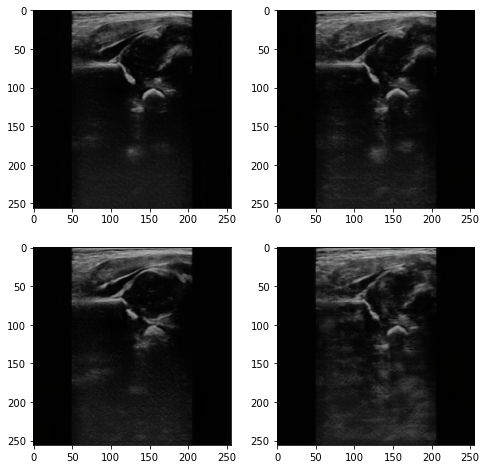

  0%|          | 0/39 [00:00<?, ?it/s]

FID: 91.6286
Epoch: 0 | D Cost: 45.07970345020294 | GP Cost: 4.891215801239014 | G Cost: 40.28994458913803 | P(aug): 0.027392 | Rt: 0.6218 | PPL Norm: 30.7059 | PPL Loss: 0.353
Epoch: 1 | D Cost: 42.33967965841293 | GP Cost: 4.282009124755859 | G Cost: 42.460357308387756 | P(aug): 0.027392 | Rt: 0.5321 | PPL Norm: 32.1617 | PPL Loss: 0.3549
Epoch: 2 | D Cost: 44.79415899515152 | GP Cost: 4.540838122367859 | G Cost: 38.59872990846634 | P(aug): 0.027648 | Rt: 0.6667 | PPL Norm: 31.2423 | PPL Loss: 0.4967
Epoch: 3 | D Cost: 43.500973641872406 | GP Cost: 5.343700528144836 | G Cost: 43.51052784919739 | P(aug): 0.027392 | Rt: 0.4904 | PPL Norm: 37.237 | PPL Loss: 0.6736
Epoch: 4 | D Cost: 45.44944655895233 | GP Cost: 5.0273357629776 | G Cost: 38.36529415845871 | P(aug): 0.027392 | Rt: 0.6474 | PPL Norm: 31.6129 | PPL Loss: 0.1847
Epoch: 5 | D Cost: 44.67304539680481 | GP Cost: 4.426849603652954 | G Cost: 41.43938112258911 | P(aug): 0.027136 | Rt: 0.516 | PPL Norm: 30.7392 | PPL Loss: 0.13
Ep

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


D(G(z)) (lower = better disc): -1.8167281
D(x) (higher = better disc): -1.0634935
D Loss: tf.Tensor(1.5859482, shape=(), dtype=float32)
G Loss: tf.Tensor(2.0240145, shape=(), dtype=float32)


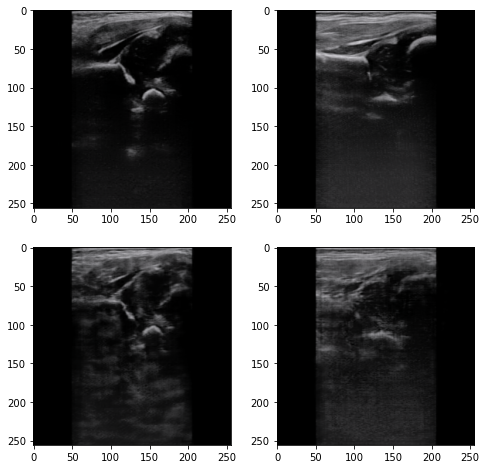

  0%|          | 0/39 [00:00<?, ?it/s]

FID: 88.3708
Epoch: 0 | D Cost: 43.6406729221344 | GP Cost: 5.334914445877075 | G Cost: 43.06498700380325 | P(aug): 0.012288 | Rt: 0.5801 | PPL Norm: 30.4019 | PPL Loss: 0.0748
Epoch: 1 | D Cost: 41.870164811611176 | GP Cost: 4.933592796325684 | G Cost: 42.751479148864746 | P(aug): 0.0128 | Rt: 0.6635 | PPL Norm: 29.9846 | PPL Loss: 0.1332
Epoch: 2 | D Cost: 42.37273812294006 | GP Cost: 5.265079736709595 | G Cost: 46.08722972869873 | P(aug): 0.012288 | Rt: 0.5545 | PPL Norm: 35.5735 | PPL Loss: 0.6567
Epoch: 3 | D Cost: 43.01164883375168 | GP Cost: 5.47279965877533 | G Cost: 40.922632813453674 | P(aug): 0.012288 | Rt: 0.6122 | PPL Norm: 31.2299 | PPL Loss: 0.0609
Epoch: 4 | D Cost: 41.65407395362854 | GP Cost: 5.11739706993103 | G Cost: 44.523603677749634 | P(aug): 0.012288 | Rt: 0.5641 | PPL Norm: 32.8424 | PPL Loss: 0.4805
Epoch: 5 | D Cost: 44.46506720781326 | GP Cost: 5.015711307525635 | G Cost: 40.291981637477875 | P(aug): 0.012288 | Rt: 0.6026 | PPL Norm: 28.6056 | PPL Loss: 0.21

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


D(G(z)) (lower = better disc): -0.76654303
D(x) (higher = better disc): 0.48948246
D Loss: tf.Tensor(0.9111903, shape=(), dtype=float32)
G Loss: tf.Tensor(1.1884539, shape=(), dtype=float32)


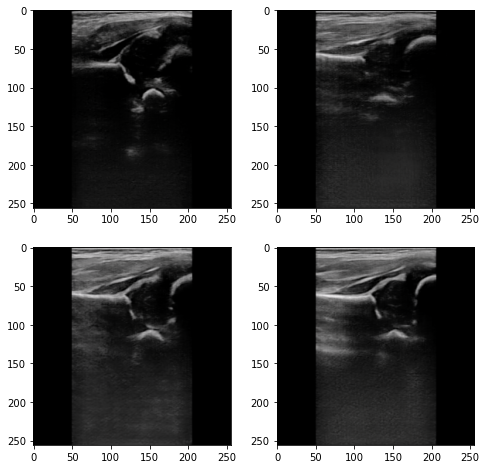

  0%|          | 0/39 [00:00<?, ?it/s]

FID: 88.1916
Epoch: 0 | D Cost: 44.333645820617676 | GP Cost: 4.159327149391174 | G Cost: 40.76045370101929 | P(aug): 0.018176 | Rt: 0.5513 | PPL Norm: 33.1647 | PPL Loss: 0.2451
Epoch: 1 | D Cost: 44.11134797334671 | GP Cost: 4.595338582992554 | G Cost: 39.63941103219986 | P(aug): 0.018432 | Rt: 0.7372 | PPL Norm: 27.8107 | PPL Loss: 0.4088
Epoch: 2 | D Cost: 42.960053622722626 | GP Cost: 4.172776818275452 | G Cost: 42.51131618022919 | P(aug): 0.018176 | Rt: 0.5577 | PPL Norm: 32.8457 | PPL Loss: 0.6545
Epoch: 3 | D Cost: 44.511591017246246 | GP Cost: 4.489501953125 | G Cost: 40.17396551370621 | P(aug): 0.018176 | Rt: 0.6795 | PPL Norm: 31.6728 | PPL Loss: 0.3644
Epoch: 4 | D Cost: 42.243637919425964 | GP Cost: 4.395238161087036 | G Cost: 42.0037003159523 | P(aug): 0.01792 | Rt: 0.6218 | PPL Norm: 34.3291 | PPL Loss: 0.2996
Epoch: 5 | D Cost: 45.001465916633606 | GP Cost: 4.770032644271851 | G Cost: 39.95123326778412 | P(aug): 0.017664 | Rt: 0.5897 | PPL Norm: 31.7908 | PPL Loss: 0.22

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


D(G(z)) (lower = better disc): -0.8529848
D(x) (higher = better disc): 2.1437106
D Loss: tf.Tensor(0.5535845, shape=(), dtype=float32)
G Loss: tf.Tensor(1.2738549, shape=(), dtype=float32)


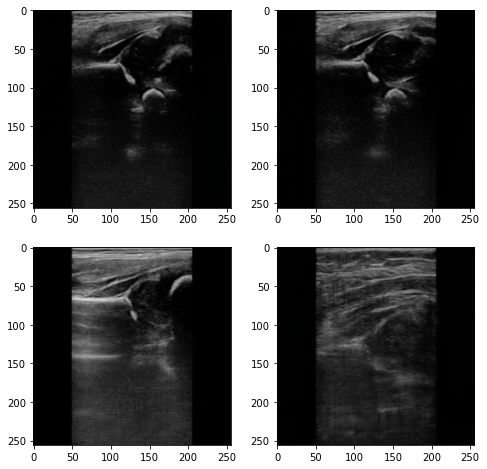

  0%|          | 0/39 [00:00<?, ?it/s]

FID: 105.5086
Epoch: 0 | D Cost: 43.758521139621735 | GP Cost: 4.4502071142196655 | G Cost: 40.382071018218994 | P(aug): 0.018432 | Rt: 0.5737 | PPL Norm: 32.0076 | PPL Loss: 0.2596
Epoch: 1 | D Cost: 45.41813611984253 | GP Cost: 4.779122948646545 | G Cost: 38.737251579761505 | P(aug): 0.018688 | Rt: 0.5833 | PPL Norm: 31.1502 | PPL Loss: 0.2427
Epoch: 2 | D Cost: 45.4903439283371 | GP Cost: 5.330231189727783 | G Cost: 42.358678460121155 | P(aug): 0.018432 | Rt: 0.5192 | PPL Norm: 34.0712 | PPL Loss: 0.2517
Epoch: 3 | D Cost: 46.05097430944443 | GP Cost: 4.460369348526001 | G Cost: 37.19740432500839 | P(aug): 0.018688 | Rt: 0.5737 | PPL Norm: 29.2648 | PPL Loss: 0.355
Epoch: 4 | D Cost: 45.87117391824722 | GP Cost: 3.744802236557007 | G Cost: 39.61209183931351 | P(aug): 0.018176 | Rt: 0.4776 | PPL Norm: 32.6914 | PPL Loss: 0.2263
Epoch: 5 | D Cost: 45.00061619281769 | GP Cost: 3.719661235809326 | G Cost: 36.582857728004456 | P(aug): 0.018688 | Rt: 0.6731 | PPL Norm: 28.9411 | PPL Loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


D(G(z)) (lower = better disc): -0.70801055
D(x) (higher = better disc): 0.92397344
D Loss: tf.Tensor(0.79844785, shape=(), dtype=float32)
G Loss: tf.Tensor(1.1407365, shape=(), dtype=float32)


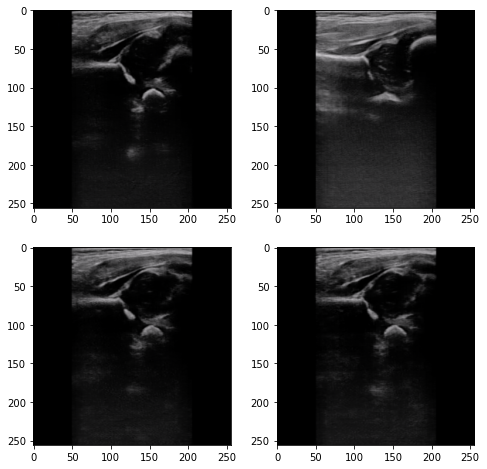

  0%|          | 0/39 [00:00<?, ?it/s]

FID: 92.6129
Epoch: 0 | D Cost: 42.52009463310242 | GP Cost: 4.5132904052734375 | G Cost: 43.4326166510582 | P(aug): 0.024832 | Rt: 0.5417 | PPL Norm: 32.9964 | PPL Loss: 0.163
Epoch: 1 | D Cost: 43.740189611911774 | GP Cost: 4.851856350898743 | G Cost: 42.086091458797455 | P(aug): 0.024832 | Rt: 0.6026 | PPL Norm: 32.9881 | PPL Loss: 0.1016
Epoch: 2 | D Cost: 43.76020586490631 | GP Cost: 4.323398590087891 | G Cost: 43.36725652217865 | P(aug): 0.024576 | Rt: 0.5865 | PPL Norm: 34.2122 | PPL Loss: 0.7449
Epoch: 3 | D Cost: 41.519757866859436 | GP Cost: 4.252842426300049 | G Cost: 45.095865190029144 | P(aug): 0.025088 | Rt: 0.6827 | PPL Norm: 32.2287 | PPL Loss: 0.149
Epoch: 4 | D Cost: 41.77372169494629 | GP Cost: 4.7759175300598145 | G Cost: 44.01184195280075 | P(aug): 0.0256 | Rt: 0.6891 | PPL Norm: 32.0306 | PPL Loss: 0.4344
Epoch: 5 | D Cost: 42.78528916835785 | GP Cost: 5.055607795715332 | G Cost: 44.670318484306335 | P(aug): 0.026112 | Rt: 0.5865 | PPL Norm: 29.4117 | PPL Loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


D(G(z)) (lower = better disc): -0.889575
D(x) (higher = better disc): 0.7677062
D Loss: tf.Tensor(0.7625221, shape=(), dtype=float32)
G Loss: tf.Tensor(1.2652617, shape=(), dtype=float32)


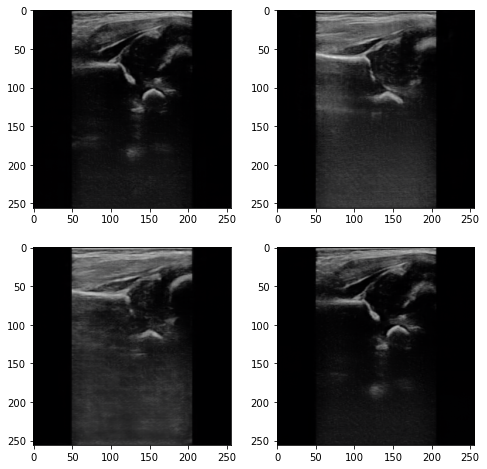

  0%|          | 0/39 [00:00<?, ?it/s]

FID: 101.5137
Epoch: 0 | D Cost: 46.518286883831024 | GP Cost: 3.9364227056503296 | G Cost: 39.254932284355164 | P(aug): 0.03584 | Rt: 0.4391 | PPL Norm: 31.1201 | PPL Loss: 0.1567
Epoch: 1 | D Cost: 48.074010372161865 | GP Cost: 4.307645916938782 | G Cost: 36.97717148065567 | P(aug): 0.03584 | Rt: 0.5385 | PPL Norm: 32.7055 | PPL Loss: 0.2144
Epoch: 2 | D Cost: 44.122675478458405 | GP Cost: 3.621108055114746 | G Cost: 39.96073621511459 | P(aug): 0.03584 | Rt: 0.5513 | PPL Norm: 35.0078 | PPL Loss: 0.9664
Epoch: 3 | D Cost: 44.45958697795868 | GP Cost: 4.507068157196045 | G Cost: 40.2981978058815 | P(aug): 0.03584 | Rt: 0.5481 | PPL Norm: 32.2902 | PPL Loss: 0.0473
Epoch: 4 | D Cost: 45.65741503238678 | GP Cost: 4.3514320850372314 | G Cost: 38.8255198597908 | P(aug): 0.03584 | Rt: 0.5769 | PPL Norm: 33.4122 | PPL Loss: 0.5874
Epoch: 5 | D Cost: 46.16025525331497 | GP Cost: 4.309074401855469 | G Cost: 41.23962813615799 | P(aug): 0.035328 | Rt: 0.4968 | PPL Norm: 29.2566 | PPL Loss: 0.35

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


D(G(z)) (lower = better disc): -0.3242957
D(x) (higher = better disc): 1.0043331
D Loss: tf.Tensor(0.892608, shape=(), dtype=float32)
G Loss: tf.Tensor(0.8860614, shape=(), dtype=float32)


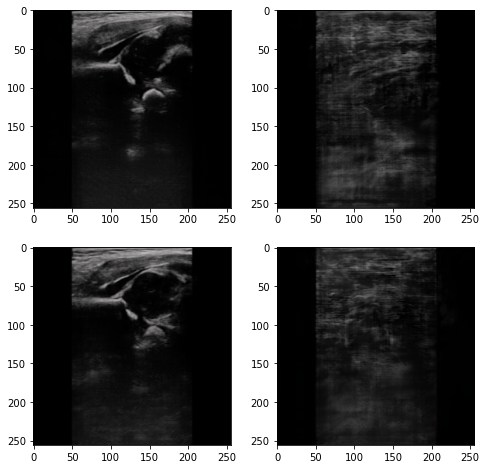

  0%|          | 0/39 [00:00<?, ?it/s]

FID: 97.0151
Epoch: 0 | D Cost: 45.103851556777954 | GP Cost: 4.64468240737915 | G Cost: 41.39608579874039 | P(aug): 0.035328 | Rt: 0.4712 | PPL Norm: 32.2676 | PPL Loss: 0.2694
Epoch: 1 | D Cost: 44.19840067625046 | GP Cost: 4.537007212638855 | G Cost: 37.8136380314827 | P(aug): 0.035328 | Rt: 0.6827 | PPL Norm: 26.7696 | PPL Loss: 0.3589
Epoch: 2 | D Cost: 45.15634298324585 | GP Cost: 4.9588528871536255 | G Cost: 41.30950206518173 | P(aug): 0.035328 | Rt: 0.4808 | PPL Norm: 31.3986 | PPL Loss: 0.2581
Epoch: 3 | D Cost: 44.57522010803223 | GP Cost: 4.699541211128235 | G Cost: 39.499933540821075 | P(aug): 0.035328 | Rt: 0.6154 | PPL Norm: 33.6146 | PPL Loss: 1.0348
Epoch: 4 | D Cost: 45.074736535549164 | GP Cost: 4.297349452972412 | G Cost: 42.36994689702988 | P(aug): 0.035072 | Rt: 0.4455 | PPL Norm: 33.2441 | PPL Loss: 0.5181
Epoch: 5 | D Cost: 45.71963316202164 | GP Cost: 4.559200763702393 | G Cost: 38.132807970047 | P(aug): 0.035072 | Rt: 0.5192 | PPL Norm: 27.5875 | PPL Loss: 0.44

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


D(G(z)) (lower = better disc): -1.4133581
D(x) (higher = better disc): 0.7693471
D Loss: tf.Tensor(0.6879008, shape=(), dtype=float32)
G Loss: tf.Tensor(1.7188106, shape=(), dtype=float32)


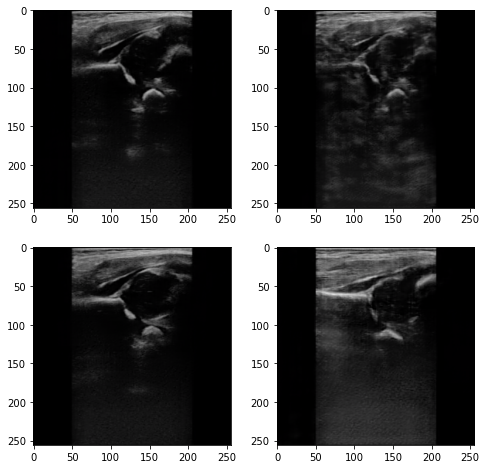

  0%|          | 0/39 [00:00<?, ?it/s]

FID: 75.7332
Epoch: 0 | D Cost: 44.37776470184326 | GP Cost: 4.523180603981018 | G Cost: 40.107030630111694 | P(aug): 0.021504 | Rt: 0.516 | PPL Norm: 32.3575 | PPL Loss: 0.6267
Epoch: 1 | D Cost: 44.9966037273407 | GP Cost: 4.814083218574524 | G Cost: 41.28403443098068 | P(aug): 0.020992 | Rt: 0.4808 | PPL Norm: 34.5728 | PPL Loss: 0.4171
Epoch: 2 | D Cost: 45.03799569606781 | GP Cost: 5.08797812461853 | G Cost: 39.176004111766815 | P(aug): 0.021248 | Rt: 0.5897 | PPL Norm: 31.0743 | PPL Loss: 0.2414
Epoch: 3 | D Cost: 45.20374411344528 | GP Cost: 4.6740312576293945 | G Cost: 39.51890033483505 | P(aug): 0.020736 | Rt: 0.5321 | PPL Norm: 30.5523 | PPL Loss: 0.131
Epoch: 4 | D Cost: 42.96553063392639 | GP Cost: 4.201276779174805 | G Cost: 40.95661550760269 | P(aug): 0.02048 | Rt: 0.5385 | PPL Norm: 26.9206 | PPL Loss: 0.2605
Epoch: 5 | D Cost: 45.04885882139206 | GP Cost: 4.864343762397766 | G Cost: 38.721853613853455 | P(aug): 0.020992 | Rt: 0.625 | PPL Norm: 29.8572 | PPL Loss: 0.2016

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


D(G(z)) (lower = better disc): -1.7108765
D(x) (higher = better disc): 0.70225143
D Loss: tf.Tensor(0.6277408, shape=(), dtype=float32)
G Loss: tf.Tensor(1.9321253, shape=(), dtype=float32)


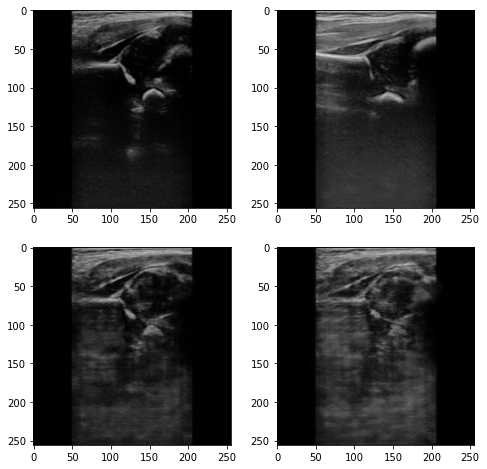

  0%|          | 0/39 [00:00<?, ?it/s]

FID: 91.9935
Epoch: 0 | D Cost: 43.742511332035065 | GP Cost: 4.993035435676575 | G Cost: 41.129314661026 | P(aug): 0.016384 | Rt: 0.6154 | PPL Norm: 35.9044 | PPL Loss: 0.981
Epoch: 1 | D Cost: 45.126012086868286 | GP Cost: 5.677712798118591 | G Cost: 42.74851471185684 | P(aug): 0.016128 | Rt: 0.5609 | PPL Norm: 33.0131 | PPL Loss: 0.6952
Epoch: 2 | D Cost: 45.114951491355896 | GP Cost: 5.942101001739502 | G Cost: 38.95872712135315 | P(aug): 0.015872 | Rt: 0.5801 | PPL Norm: 30.0006 | PPL Loss: 0.2227
Epoch: 3 | D Cost: 45.87505477666855 | GP Cost: 4.545940518379211 | G Cost: 40.60095477104187 | P(aug): 0.016128 | Rt: 0.5224 | PPL Norm: 30.1088 | PPL Loss: 0.4545
Epoch: 4 | D Cost: 44.01659882068634 | GP Cost: 4.270655035972595 | G Cost: 39.02537429332733 | P(aug): 0.016128 | Rt: 0.641 | PPL Norm: 33.5758 | PPL Loss: 0.286
Epoch: 5 | D Cost: 45.42506688833237 | GP Cost: 4.8334643840789795 | G Cost: 40.26776283979416 | P(aug): 0.016384 | Rt: 0.5128 | PPL Norm: 33.1326 | PPL Loss: 0.443

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


D(G(z)) (lower = better disc): -1.5733429
D(x) (higher = better disc): 0.84410775
D Loss: tf.Tensor(0.56391454, shape=(), dtype=float32)
G Loss: tf.Tensor(1.773202, shape=(), dtype=float32)


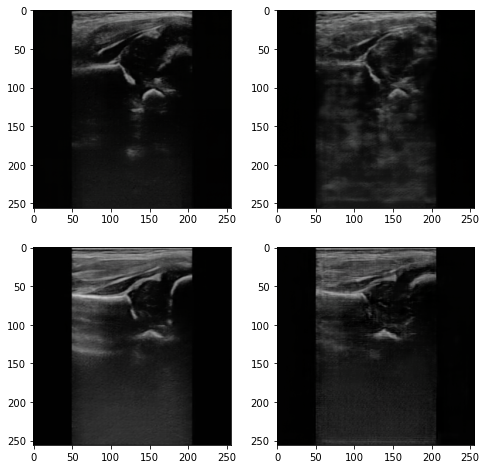

  0%|          | 0/39 [00:00<?, ?it/s]

FID: 91.1586
Epoch: 0 | D Cost: 43.59297704696655 | GP Cost: 4.810054540634155 | G Cost: 42.452839851379395 | P(aug): 0.0128 | Rt: 0.5321 | PPL Norm: 29.2378 | PPL Loss: 0.1265
Epoch: 1 | D Cost: 44.39305716753006 | GP Cost: 5.709819436073303 | G Cost: 38.362744212150574 | P(aug): 0.012544 | Rt: 0.6122 | PPL Norm: 33.1578 | PPL Loss: 0.3997
Epoch: 2 | D Cost: 44.04951536655426 | GP Cost: 4.645930051803589 | G Cost: 42.03159707784653 | P(aug): 0.012288 | Rt: 0.4263 | PPL Norm: 29.7636 | PPL Loss: 0.1038
Epoch: 3 | D Cost: 44.74641036987305 | GP Cost: 4.813748478889465 | G Cost: 40.35812312364578 | P(aug): 0.012032 | Rt: 0.5481 | PPL Norm: 30.3315 | PPL Loss: 0.0775
Epoch: 4 | D Cost: 43.746649980545044 | GP Cost: 4.948357105255127 | G Cost: 40.988578259944916 | P(aug): 0.012032 | Rt: 0.5801 | PPL Norm: 35.4727 | PPL Loss: 0.6807
Epoch: 5 | D Cost: 45.06165200471878 | GP Cost: 4.6504528522491455 | G Cost: 40.912923872470856 | P(aug): 0.012032 | Rt: 0.5256 | PPL Norm: 31.697 | PPL Loss: 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


D(G(z)) (lower = better disc): -0.53556436
D(x) (higher = better disc): 0.052415907
D Loss: tf.Tensor(1.1390268, shape=(), dtype=float32)
G Loss: tf.Tensor(1.00205, shape=(), dtype=float32)


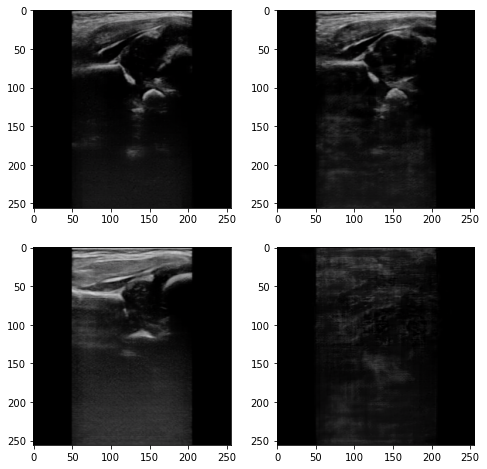

  0%|          | 0/39 [00:00<?, ?it/s]

FID: 84.0517
Epoch: 0 | D Cost: 42.20298361778259 | GP Cost: 5.412280797958374 | G Cost: 42.75866252183914 | P(aug): 0.005888 | Rt: 0.6731 | PPL Norm: 29.4683 | PPL Loss: 0.2151
Epoch: 1 | D Cost: 45.96358633041382 | GP Cost: 5.7397966384887695 | G Cost: 41.98446422815323 | P(aug): 0.005632 | Rt: 0.4936 | PPL Norm: 34.0032 | PPL Loss: 0.2008
Epoch: 2 | D Cost: 42.2046759724617 | GP Cost: 5.062572717666626 | G Cost: 43.32753086090088 | P(aug): 0.005888 | Rt: 0.6282 | PPL Norm: 27.4329 | PPL Loss: 0.7534
Epoch: 3 | D Cost: 42.38049793243408 | GP Cost: 4.844748497009277 | G Cost: 43.80700242519379 | P(aug): 0.006144 | Rt: 0.625 | PPL Norm: 28.9089 | PPL Loss: 0.1474
Epoch: 4 | D Cost: 43.22170841693878 | GP Cost: 4.841333389282227 | G Cost: 42.35776150226593 | P(aug): 0.0064 | Rt: 0.5737 | PPL Norm: 28.2646 | PPL Loss: 0.2506
Epoch: 5 | D Cost: 42.92639249563217 | GP Cost: 4.622263193130493 | G Cost: 42.72524052858353 | P(aug): 0.006144 | Rt: 0.5353 | PPL Norm: 34.155 | PPL Loss: 0.1582
E

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


D(G(z)) (lower = better disc): -1.051507
D(x) (higher = better disc): 0.6100728
D Loss: tf.Tensor(0.7619344, shape=(), dtype=float32)
G Loss: tf.Tensor(1.378451, shape=(), dtype=float32)


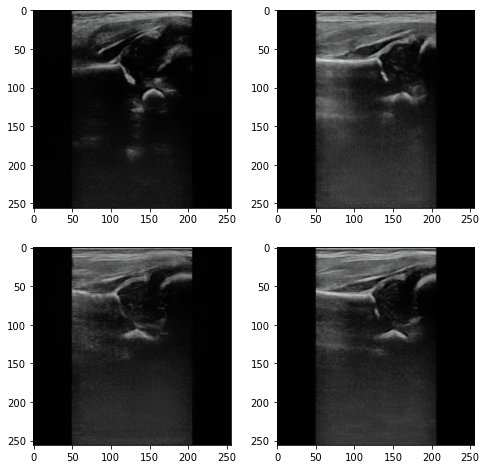

  0%|          | 0/39 [00:00<?, ?it/s]

FID: 91.6212
Epoch: 0 | D Cost: 44.65343260765076 | GP Cost: 5.144904613494873 | G Cost: 41.013626396656036 | P(aug): 0.0032 | Rt: 0.6378 | PPL Norm: 32.5431 | PPL Loss: 0.1851
Epoch: 1 | D Cost: 43.850958466529846 | GP Cost: 5.092916369438171 | G Cost: 40.906010806560516 | P(aug): 0.002944 | Rt: 0.5545 | PPL Norm: 29.4868 | PPL Loss: 0.1569
Epoch: 2 | D Cost: 45.161351919174194 | GP Cost: 4.8597893714904785 | G Cost: 40.296949684619904 | P(aug): 0.002944 | Rt: 0.6282 | PPL Norm: 29.4992 | PPL Loss: 0.1537
Epoch: 3 | D Cost: 43.24434834718704 | GP Cost: 5.109007477760315 | G Cost: 41.79168039560318 | P(aug): 0.002944 | Rt: 0.5769 | PPL Norm: 32.4223 | PPL Loss: 0.3671
Epoch: 4 | D Cost: 42.62468409538269 | GP Cost: 4.538440704345703 | G Cost: 41.14109027385712 | P(aug): 0.002944 | Rt: 0.5192 | PPL Norm: 33.2855 | PPL Loss: 0.6828
Epoch: 5 | D Cost: 42.541344702243805 | GP Cost: 4.780946135520935 | G Cost: 42.280915796756744 | P(aug): 0.003456 | Rt: 0.6474 | PPL Norm: 30.2909 | PPL Loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


D(G(z)) (lower = better disc): -1.2493825
D(x) (higher = better disc): 1.0797253
D Loss: tf.Tensor(0.57719225, shape=(), dtype=float32)
G Loss: tf.Tensor(1.516513, shape=(), dtype=float32)


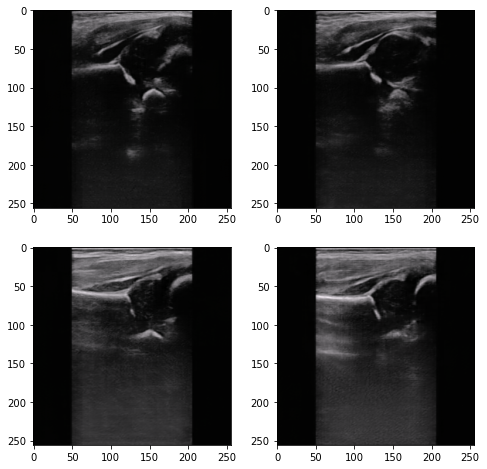

  0%|          | 0/39 [00:00<?, ?it/s]

FID: 87.3773
Epoch: 0 | D Cost: 44.504162430763245 | GP Cost: 6.300660133361816 | G Cost: 41.65429383516312 | P(aug): 0.008064 | Rt: 0.5769 | PPL Norm: 35.7082 | PPL Loss: 0.4498
Epoch: 1 | D Cost: 43.64483445882797 | GP Cost: 4.588092923164368 | G Cost: 42.010828137397766 | P(aug): 0.008064 | Rt: 0.5481 | PPL Norm: 29.9741 | PPL Loss: 0.1966
Epoch: 2 | D Cost: 43.129759311676025 | GP Cost: 4.841429829597473 | G Cost: 40.58067947626114 | P(aug): 0.00832 | Rt: 0.6635 | PPL Norm: 29.976 | PPL Loss: 0.2922
Epoch: 3 | D Cost: 44.90784156322479 | GP Cost: 5.046593427658081 | G Cost: 41.28019297122955 | P(aug): 0.00832 | Rt: 0.5641 | PPL Norm: 36.6764 | PPL Loss: 0.8162
Epoch: 4 | D Cost: 43.204547226428986 | GP Cost: 4.517099022865295 | G Cost: 39.68239587545395 | P(aug): 0.008576 | Rt: 0.6378 | PPL Norm: 33.1804 | PPL Loss: 0.1328
Epoch: 5 | D Cost: 42.29306524991989 | GP Cost: 4.49392831325531 | G Cost: 39.63361418247223 | P(aug): 0.00832 | Rt: 0.5929 | PPL Norm: 30.9213 | PPL Loss: 0.229

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


D(G(z)) (lower = better disc): -2.048391
D(x) (higher = better disc): 0.7786238
D Loss: tf.Tensor(0.569118, shape=(), dtype=float32)
G Loss: tf.Tensor(2.2085354, shape=(), dtype=float32)


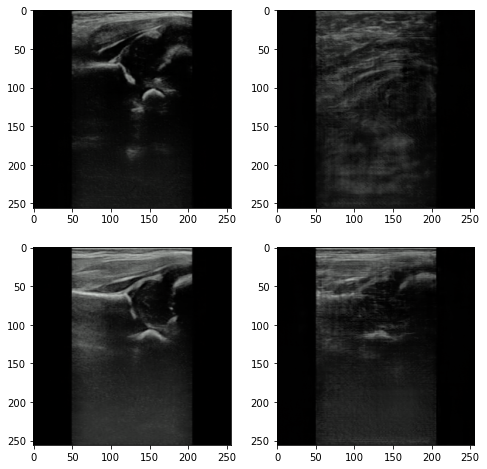

  0%|          | 0/39 [00:00<?, ?it/s]

FID: 100.0467
Epoch: 0 | D Cost: 44.19517195224762 | GP Cost: 5.545588731765747 | G Cost: 40.985069274902344 | P(aug): 0.024448 | Rt: 0.5609 | PPL Norm: 29.8808 | PPL Loss: 0.402
Epoch: 1 | D Cost: 42.76834028959274 | GP Cost: 4.4961254596710205 | G Cost: 41.58067888021469 | P(aug): 0.025216 | Rt: 0.7276 | PPL Norm: 32.9333 | PPL Loss: 0.0549
Epoch: 2 | D Cost: 44.28713607788086 | GP Cost: 4.89286732673645 | G Cost: 41.186461210250854 | P(aug): 0.025472 | Rt: 0.6506 | PPL Norm: 28.5025 | PPL Loss: 0.527
Epoch: 3 | D Cost: 43.614332020282745 | GP Cost: 5.186182975769043 | G Cost: 41.38598722219467 | P(aug): 0.025216 | Rt: 0.6122 | PPL Norm: 34.1715 | PPL Loss: 0.6758
Epoch: 4 | D Cost: 43.53158450126648 | GP Cost: 4.871035099029541 | G Cost: 40.68557894229889 | P(aug): 0.025216 | Rt: 0.6186 | PPL Norm: 29.4152 | PPL Loss: 0.1896
Epoch: 5 | D Cost: 44.249948263168335 | GP Cost: 5.0540889501571655 | G Cost: 42.0152832865715 | P(aug): 0.025472 | Rt: 0.6442 | PPL Norm: 30.2465 | PPL Loss: 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


D(G(z)) (lower = better disc): -0.7551743
D(x) (higher = better disc): 0.18820465
D Loss: tf.Tensor(1.053489, shape=(), dtype=float32)
G Loss: tf.Tensor(1.180871, shape=(), dtype=float32)


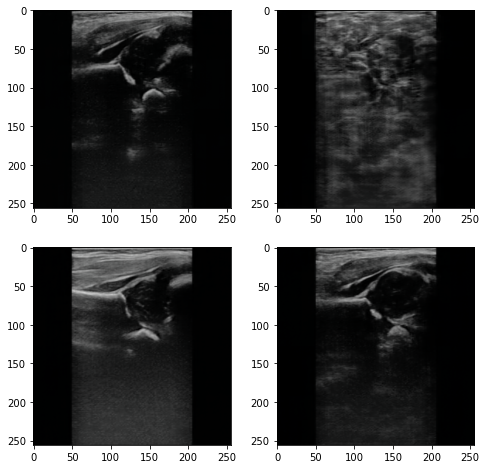

  0%|          | 0/39 [00:00<?, ?it/s]

FID: 99.6309
Epoch: 0 | D Cost: 42.65139889717102 | GP Cost: 4.9589163064956665 | G Cost: 40.81557297706604 | P(aug): 0.014464 | Rt: 0.5256 | PPL Norm: 31.3195 | PPL Loss: 0.3017
Epoch: 1 | D Cost: 44.298378586769104 | GP Cost: 4.1784127950668335 | G Cost: 39.894523322582245 | P(aug): 0.014208 | Rt: 0.5288 | PPL Norm: 28.8038 | PPL Loss: 0.1374
Epoch: 2 | D Cost: 42.77662891149521 | GP Cost: 4.4879714250564575 | G Cost: 42.18168419599533 | P(aug): 0.013952 | Rt: 0.5641 | PPL Norm: 34.822 | PPL Loss: 0.5351
Epoch: 3 | D Cost: 41.989077627658844 | GP Cost: 4.357937455177307 | G Cost: 41.4665065407753 | P(aug): 0.013952 | Rt: 0.609 | PPL Norm: 31.1338 | PPL Loss: 0.0861
Epoch: 4 | D Cost: 43.658642530441284 | GP Cost: 4.943952560424805 | G Cost: 40.41074275970459 | P(aug): 0.01344 | Rt: 0.5 | PPL Norm: 30.0202 | PPL Loss: 0.1958
Epoch: 5 | D Cost: 42.8651162981987 | GP Cost: 5.078066110610962 | G Cost: 45.29852241277695 | P(aug): 0.013184 | Rt: 0.5481 | PPL Norm: 36.474 | PPL Loss: 2.9967

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


D(G(z)) (lower = better disc): -1.7108116
D(x) (higher = better disc): 0.9824854
D Loss: tf.Tensor(0.51111245, shape=(), dtype=float32)
G Loss: tf.Tensor(1.8945434, shape=(), dtype=float32)


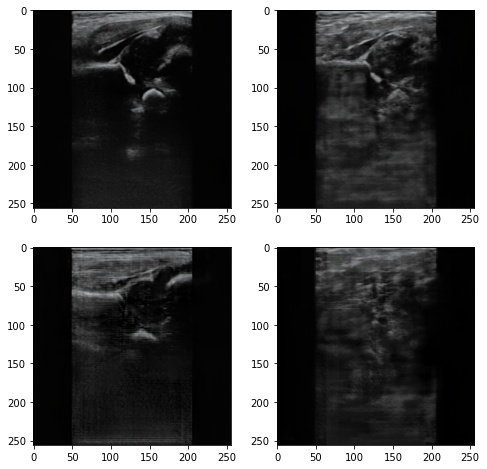

  0%|          | 0/39 [00:00<?, ?it/s]

FID: 84.8556
Epoch: 0 | D Cost: 43.04124343395233 | GP Cost: 5.008391976356506 | G Cost: 39.74994170665741 | P(aug): 0.017024 | Rt: 0.6891 | PPL Norm: 32.4377 | PPL Loss: 0.1818
Epoch: 1 | D Cost: 44.905764162540436 | GP Cost: 4.715288400650024 | G Cost: 41.23112964630127 | P(aug): 0.017024 | Rt: 0.5417 | PPL Norm: 31.2767 | PPL Loss: 0.0156
Epoch: 2 | D Cost: 44.86787527799606 | GP Cost: 4.680486559867859 | G Cost: 39.572359681129456 | P(aug): 0.017536 | Rt: 0.6058 | PPL Norm: 29.8704 | PPL Loss: 0.3396
Epoch: 3 | D Cost: 45.21676552295685 | GP Cost: 4.669370889663696 | G Cost: 40.61000680923462 | P(aug): 0.017536 | Rt: 0.5096 | PPL Norm: 31.9311 | PPL Loss: 0.2236
Epoch: 4 | D Cost: 45.73994171619415 | GP Cost: 4.668246626853943 | G Cost: 38.744316816329956 | P(aug): 0.017536 | Rt: 0.5994 | PPL Norm: 29.8464 | PPL Loss: 0.1814
Epoch: 5 | D Cost: 43.64026129245758 | GP Cost: 4.829559803009033 | G Cost: 39.32658660411835 | P(aug): 0.018048 | Rt: 0.6795 | PPL Norm: 34.2122 | PPL Loss: 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


D(G(z)) (lower = better disc): -1.0385158
D(x) (higher = better disc): -0.06397861
D Loss: tf.Tensor(1.0320702, shape=(), dtype=float32)
G Loss: tf.Tensor(1.3436971, shape=(), dtype=float32)


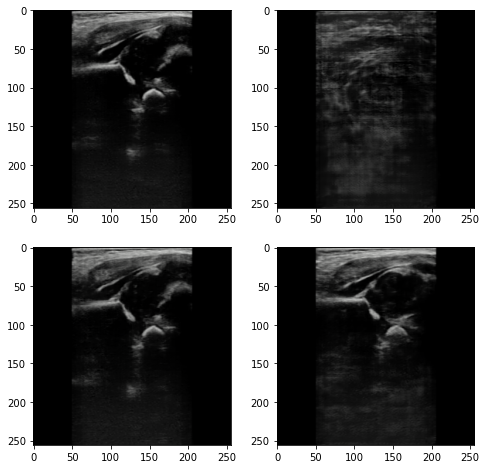

  0%|          | 0/39 [00:00<?, ?it/s]

FID: 79.3684
Epoch: 0 | D Cost: 43.007654905319214 | GP Cost: 4.676148056983948 | G Cost: 40.89180541038513 | P(aug): 0.018048 | Rt: 0.6346 | PPL Norm: 35.6444 | PPL Loss: 0.5563
Epoch: 1 | D Cost: 43.341302275657654 | GP Cost: 5.1287147998809814 | G Cost: 42.07654410600662 | P(aug): 0.017536 | Rt: 0.5673 | PPL Norm: 31.3923 | PPL Loss: 0.3412
Epoch: 2 | D Cost: 45.125391364097595 | GP Cost: 4.589061617851257 | G Cost: 37.44791001081467 | P(aug): 0.017792 | Rt: 0.5929 | PPL Norm: 32.244 | PPL Loss: 0.3182
Epoch: 3 | D Cost: 44.748898684978485 | GP Cost: 4.610955715179443 | G Cost: 39.67735409736633 | P(aug): 0.01728 | Rt: 0.5481 | PPL Norm: 32.9874 | PPL Loss: 0.3727
Epoch: 4 | D Cost: 44.221100091934204 | GP Cost: 5.0226017236709595 | G Cost: 43.35845339298248 | P(aug): 0.017536 | Rt: 0.625 | PPL Norm: 31.2518 | PPL Loss: 0.4363
Epoch: 5 | D Cost: 43.922900795936584 | GP Cost: 4.342111945152283 | G Cost: 40.07724779844284 | P(aug): 0.017536 | Rt: 0.6795 | PPL Norm: 30.8363 | PPL Loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


D(G(z)) (lower = better disc): -1.5439507
D(x) (higher = better disc): 1.0952662
D Loss: tf.Tensor(0.5240827, shape=(), dtype=float32)
G Loss: tf.Tensor(1.7683516, shape=(), dtype=float32)


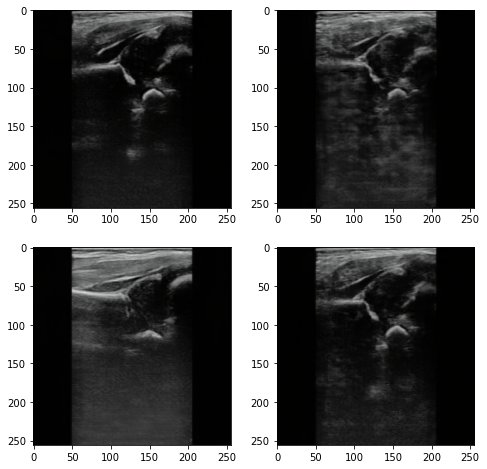

  0%|          | 0/39 [00:00<?, ?it/s]

FID: 99.4298
Epoch: 0 | D Cost: 44.49408847093582 | GP Cost: 4.708503842353821 | G Cost: 39.01595163345337 | P(aug): 0.024704 | Rt: 0.7276 | PPL Norm: 29.6491 | PPL Loss: 0.3323
Epoch: 1 | D Cost: 45.46425241231918 | GP Cost: 4.658391237258911 | G Cost: 38.5408171415329 | P(aug): 0.024192 | Rt: 0.5256 | PPL Norm: 31.3312 | PPL Loss: 0.1868
Epoch: 2 | D Cost: 45.71854382753372 | GP Cost: 4.166442155838013 | G Cost: 39.9797061085701 | P(aug): 0.023936 | Rt: 0.4776 | PPL Norm: 34.5056 | PPL Loss: 0.3164
Epoch: 3 | D Cost: 44.22041606903076 | GP Cost: 4.499581336975098 | G Cost: 39.84030431509018 | P(aug): 0.02368 | Rt: 0.5224 | PPL Norm: 31.9723 | PPL Loss: 0.2058
Epoch: 4 | D Cost: 44.70590788125992 | GP Cost: 4.722430944442749 | G Cost: 37.72589486837387 | P(aug): 0.024448 | Rt: 0.6538 | PPL Norm: 29.0418 | PPL Loss: 0.2893
Epoch: 5 | D Cost: 45.347930669784546 | GP Cost: 4.362541556358337 | G Cost: 38.53906035423279 | P(aug): 0.02368 | Rt: 0.5449 | PPL Norm: 35.9368 | PPL Loss: 0.3694


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


D(G(z)) (lower = better disc): -1.1647648
D(x) (higher = better disc): -0.025411963
D Loss: tf.Tensor(1.0274162, shape=(), dtype=float32)
G Loss: tf.Tensor(1.4758122, shape=(), dtype=float32)


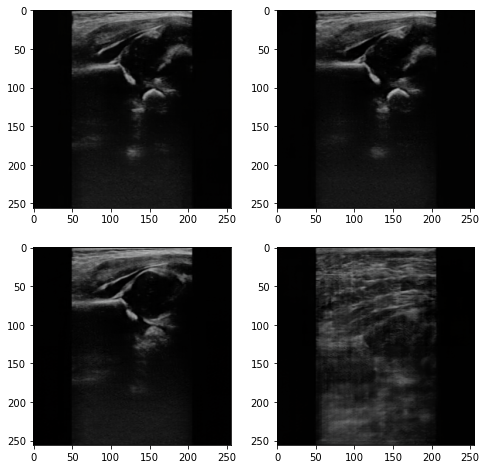

  0%|          | 0/39 [00:00<?, ?it/s]

FID: 79.4083
Epoch: 0 | D Cost: 44.802215218544006 | GP Cost: 5.448293328285217 | G Cost: 41.21786820888519 | P(aug): 0.015232 | Rt: 0.5673 | PPL Norm: 32.5216 | PPL Loss: 0.5252
Epoch: 1 | D Cost: 44.716163635253906 | GP Cost: 5.4222636222839355 | G Cost: 39.30343556404114 | P(aug): 0.015744 | Rt: 0.6571 | PPL Norm: 30.4058 | PPL Loss: 0.1976
Epoch: 2 | D Cost: 41.53053027391434 | GP Cost: 4.6704264879226685 | G Cost: 40.396109223365784 | P(aug): 0.016512 | Rt: 0.7756 | PPL Norm: 29.6619 | PPL Loss: 0.0514
Epoch: 3 | D Cost: 42.37119686603546 | GP Cost: 5.2536457777023315 | G Cost: 41.723292112350464 | P(aug): 0.016512 | Rt: 0.5705 | PPL Norm: 27.5865 | PPL Loss: 0.1775
Epoch: 4 | D Cost: 42.58968132734299 | GP Cost: 5.299335479736328 | G Cost: 43.29619264602661 | P(aug): 0.016768 | Rt: 0.6474 | PPL Norm: 26.3511 | PPL Loss: 0.2992
Epoch: 5 | D Cost: 45.196170806884766 | GP Cost: 4.791621088981628 | G Cost: 38.74385476112366 | P(aug): 0.016768 | Rt: 0.5833 | PPL Norm: 34.3762 | PPL Lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


D(G(z)) (lower = better disc): -1.2973845
D(x) (higher = better disc): 0.07971679
D Loss: tf.Tensor(0.9205332, shape=(), dtype=float32)
G Loss: tf.Tensor(1.5564008, shape=(), dtype=float32)


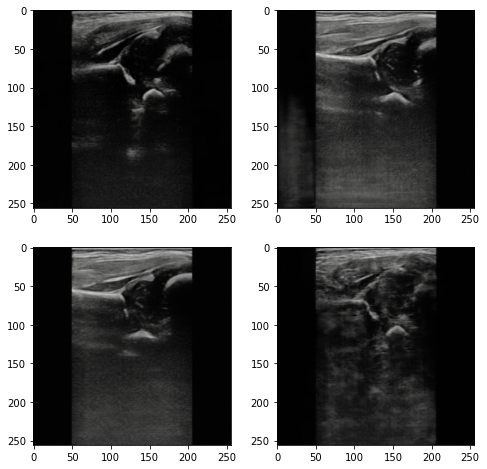

  0%|          | 0/39 [00:00<?, ?it/s]

FID: 99.3769
Epoch: 0 | D Cost: 43.79474425315857 | GP Cost: 4.9280266761779785 | G Cost: 37.59328955411911 | P(aug): 0.015232 | Rt: 0.5641 | PPL Norm: 28.5045 | PPL Loss: 0.1496
Epoch: 1 | D Cost: 44.41726911067963 | GP Cost: 4.3701863288879395 | G Cost: 41.61170715093613 | P(aug): 0.015488 | Rt: 0.5256 | PPL Norm: 31.4655 | PPL Loss: 0.5893
Epoch: 2 | D Cost: 42.257231533527374 | GP Cost: 4.726067066192627 | G Cost: 39.825955510139465 | P(aug): 0.015744 | Rt: 0.6346 | PPL Norm: 30.4392 | PPL Loss: 0.1377
Epoch: 3 | D Cost: 47.0404948592186 | GP Cost: 4.541501760482788 | G Cost: 40.15297597646713 | P(aug): 0.015488 | Rt: 0.4391 | PPL Norm: 31.8687 | PPL Loss: 0.1949
Epoch: 4 | D Cost: 44.82859128713608 | GP Cost: 5.146232724189758 | G Cost: 42.173338651657104 | P(aug): 0.015488 | Rt: 0.5192 | PPL Norm: 28.1344 | PPL Loss: 0.1255
Epoch: 5 | D Cost: 45.13887673616409 | GP Cost: 4.422277331352234 | G Cost: 40.03157603740692 | P(aug): 0.015232 | Rt: 0.4615 | PPL Norm: 33.8764 | PPL Loss: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


D(G(z)) (lower = better disc): -2.1232061
D(x) (higher = better disc): 0.23333816
D Loss: tf.Tensor(0.72914463, shape=(), dtype=float32)
G Loss: tf.Tensor(2.2626386, shape=(), dtype=float32)


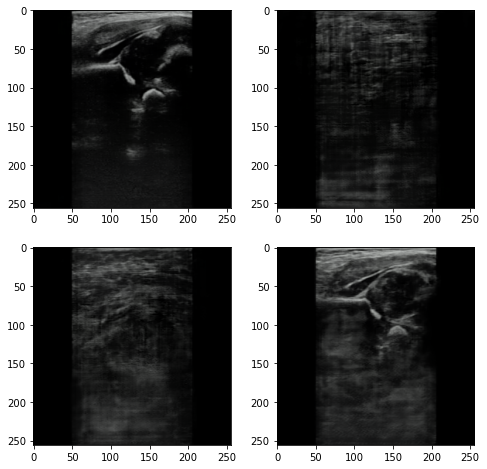

  0%|          | 0/39 [00:00<?, ?it/s]

FID: 91.4837
Epoch: 0 | D Cost: 42.683057725429535 | GP Cost: 5.128139615058899 | G Cost: 43.17870831489563 | P(aug): 0.001152 | Rt: 0.6538 | PPL Norm: 29.4159 | PPL Loss: 0.1102
Epoch: 1 | D Cost: 43.178673923015594 | GP Cost: 5.0514326095581055 | G Cost: 41.81623125076294 | P(aug): 0.001408 | Rt: 0.6506 | PPL Norm: 35.0316 | PPL Loss: 0.4266
Epoch: 2 | D Cost: 43.42644488811493 | GP Cost: 5.37288773059845 | G Cost: 41.42317509651184 | P(aug): 0.00192 | Rt: 0.6314 | PPL Norm: 32.1074 | PPL Loss: 0.3228
Epoch: 3 | D Cost: 43.550909876823425 | GP Cost: 5.129075407981873 | G Cost: 43.522677421569824 | P(aug): 0.002688 | Rt: 0.6827 | PPL Norm: 34.3426 | PPL Loss: 0.3296
Epoch: 4 | D Cost: 43.66475450992584 | GP Cost: 4.9485087394714355 | G Cost: 41.837215065956116 | P(aug): 0.002688 | Rt: 0.6058 | PPL Norm: 31.8861 | PPL Loss: 0.6532
Epoch: 5 | D Cost: 41.40968829393387 | GP Cost: 4.773210525512695 | G Cost: 42.83489042520523 | P(aug): 0.002944 | Rt: 0.7244 | PPL Norm: 32.1853 | PPL Loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


D(G(z)) (lower = better disc): -1.3692825
D(x) (higher = better disc): 0.037176855
D Loss: tf.Tensor(0.96003735, shape=(), dtype=float32)
G Loss: tf.Tensor(1.6539998, shape=(), dtype=float32)


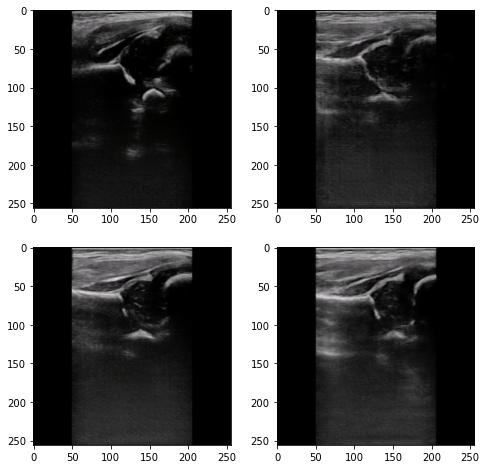

  0%|          | 0/39 [00:00<?, ?it/s]

FID: 87.4152
Epoch: 0 | D Cost: 43.4814555644989 | GP Cost: 4.816292643547058 | G Cost: 41.659724831581116 | P(aug): 0.014464 | Rt: 0.5545 | PPL Norm: 27.1226 | PPL Loss: 0.1957
Epoch: 1 | D Cost: 43.420874893665314 | GP Cost: 4.941981673240662 | G Cost: 41.51997745037079 | P(aug): 0.014976 | Rt: 0.6923 | PPL Norm: 32.4364 | PPL Loss: 0.2058
Epoch: 2 | D Cost: 43.88594037294388 | GP Cost: 4.73429536819458 | G Cost: 42.27409762144089 | P(aug): 0.01472 | Rt: 0.5897 | PPL Norm: 27.9226 | PPL Loss: 0.2219
Epoch: 3 | D Cost: 44.99326229095459 | GP Cost: 4.935736417770386 | G Cost: 39.1339373588562 | P(aug): 0.01472 | Rt: 0.5929 | PPL Norm: 28.4149 | PPL Loss: 0.2366
Epoch: 4 | D Cost: 44.45969212055206 | GP Cost: 4.767587423324585 | G Cost: 42.097579538822174 | P(aug): 0.014464 | Rt: 0.5096 | PPL Norm: 28.697 | PPL Loss: 0.3363
Epoch: 5 | D Cost: 44.32638919353485 | GP Cost: 4.79297411441803 | G Cost: 39.85395497083664 | P(aug): 0.014976 | Rt: 0.7019 | PPL Norm: 28.0308 | PPL Loss: 0.3116
E

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


D(G(z)) (lower = better disc): -1.273833
D(x) (higher = better disc): -0.07949865
D Loss: tf.Tensor(1.0035064, shape=(), dtype=float32)
G Loss: tf.Tensor(1.5383544, shape=(), dtype=float32)


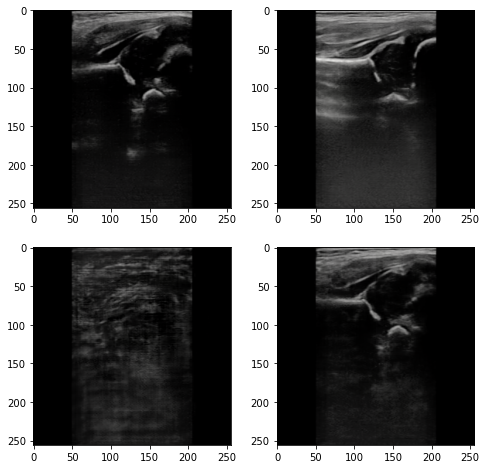

  0%|          | 0/39 [00:00<?, ?it/s]

FID: 88.8463
Epoch: 0 | D Cost: 43.413827776908875 | GP Cost: 4.167039394378662 | G Cost: 40.892516791820526 | P(aug): 0.012928 | Rt: 0.6827 | PPL Norm: 27.9055 | PPL Loss: 0.4707
Epoch: 1 | D Cost: 42.66793143749237 | GP Cost: 4.384647011756897 | G Cost: 41.537758588790894 | P(aug): 0.013184 | Rt: 0.6058 | PPL Norm: 28.916 | PPL Loss: 0.0503
Epoch: 2 | D Cost: 43.12220776081085 | GP Cost: 5.098196268081665 | G Cost: 43.032319486141205 | P(aug): 0.012672 | Rt: 0.5705 | PPL Norm: 32.4207 | PPL Loss: 0.38
Epoch: 3 | D Cost: 44.42143535614014 | GP Cost: 5.357752203941345 | G Cost: 40.14044040441513 | P(aug): 0.013184 | Rt: 0.6923 | PPL Norm: 29.2405 | PPL Loss: 0.2174
Epoch: 4 | D Cost: 43.71142601966858 | GP Cost: 5.7824472188949585 | G Cost: 41.534002125263214 | P(aug): 0.012928 | Rt: 0.5801 | PPL Norm: 27.9787 | PPL Loss: 0.0795
Epoch: 5 | D Cost: 42.26162779331207 | GP Cost: 4.72415018081665 | G Cost: 38.83431112766266 | P(aug): 0.01344 | Rt: 0.7532 | PPL Norm: 27.4849 | PPL Loss: 0.1

In [18]:
constZ = npr.randn(zdim,)
constNoise = npr.randn(imgSize, imgSize, 1)
epoch =0
if type(reals) != np.ndarray or type(ds) == type(None):
        loadData()

while True:
    sess = timeIt('Training')
    display(z1=npr.randn(rows * cols, zdim), z2=npr.randn(rows * cols, zdim), noise=npr.randn(rows * cols, imgSize, imgSize, 1), verbose=True)
    train(epochs=100)
    epoch += 1
    sess.close()
    save_models(epoch,askInp=False)
    np.save(os.path.join(modelPath, 'p.npy'), p) # save p value for future training if training on servers with time limits like Paperspace

Visualize gradients

In [ ]:
if type(reals) != np.ndarray or type(ds) == type(None):
    #loadData()
    reals = np.load(os.path.join(datasetPath, 'imgs.npy'))
    m = batchSize * (reals.shape[0] // batchSize)
    reals = reals[:m].astype(np.float32)

    assert reals.shape[0] % batchSize == 0
    assert type(reals) == np.ndarray
    ds = (tf.data.Dataset.from_tensor_slices(tf.cast(reals, tf.float32)).shuffle(3000).batch(batchSize))
    ds = ds.prefetch(AUTO)
    gc.collect()

dGrad, gGrad, dNorm, gNorm, img, fake, truePreds, fakePreds = retGrads(reals[35])
dGrad = np.sum(dGrad, axis=2)
gGrad = np.sum(gGrad, axis=2)
print('D(x): {} | D(G(z)): {}'.format(truePreds, fakePreds))
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
dGrad = (dGrad - np.min(dGrad)) / (np.max(dGrad) - np.min(dGrad) + eps)
gGrad = (gGrad - np.min(gGrad)) / (np.max(gGrad) - np.min(gGrad) + eps)
axes[0][0].imshow(img/2+0.5)
axes[0][1].imshow(fake/2+0.5)
axes[1][0].imshow(dGrad)
axes[1][0].set_title('Real Grad; Norm: {}'.format(round(dNorm, 4)))
axes[1][1].imshow(gGrad)
axes[1][1].set_title('Fake Grad; Norm: {}'.format(round(gNorm, 4)))
plt.show()

Visualize mapping activations

In [ ]:
z = npr.randn(1, zdim)
w = mapper.predict(z)
plt.imshow(z[0].reshape(16, 16))
plt.colorbar()
plt.show()
plt.imshow(w[0].reshape(16, 16))
plt.colorbar()
plt.show()

See generated images

In [ ]:
try:
    constZ1s
except Exception as e:
    constZ1s = npr.randn(rows*cols, zdim)
    constZ2s = npr.randn(rows*cols, zdim)
    constNoises = npr.randn(rows * cols, imgSize, imgSize, 1)

'''
if z1s commented out, same content, different styles
if z2s commented out, different content, same styles
if noise = 0, undesirably smooth faces but just a test to make sure styles are working properly
'''
for i in range(1): 
    constZ1s = npr.randn(rows * cols, zdim)
    #constZ2s = npr.randn(rows * cols, zdim)
    constNoises = npr.randn(rows * cols, imgSize, imgSize, 1) * 0
    pred11=display(z1=constZ1s, z2=constZ2s, noise=constNoises, verbose=False)

In [ ]:
import cv2  
for j in range(911):
    constZ1s = npr.randn(rows*10, zdim)
    constZ2s = npr.randn(rows*10, zdim)
    constNoises = npr.randn(rows * 10, imgSize, imgSize, 1)
    

    z1 = constZ1s; z2 = constZ2s; noise = constNoises

    randInds = npr.randint(0, reals.shape[0], (rows*10,))
        
    w1 = mapper(z1, training=False)
    w2 = mapper(z2, training=False)
    ws = [w1 for i in range(teps)] + [w2 for i in range(4)]
    preds = generator([*ws, noise], training=False)

    for i in range(5):
        img=preds[i].numpy() / 2 + 0.5
        img=((img-img.min())*255/(img-img.min()).max())
        img= cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        cv2.imwrite("../../data/6_Train_styleGAN/pred/pred"+str(j*5+i)+".jpg",img)



See metrics over training

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))
pltX = range(len(dcosts))
gcosts1=np.array(gcosts)
axes[0].plot(pltX, dcosts); axes[0].set_title('D Loss')
axes[1].plot(pltX, gcosts1); axes[1].set_title('G Loss')
axes[2].plot(pltX, gpcosts); axes[2].set_title('GP')
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))
axes[0].plot(pltX, ps); axes[0].set_title('Evolution of P(aug) over training')
axes[1].plot(pltX, rts); axes[1].set_title('Evolution of r_t')
axes[2].plot(pltX, pplNorms); axes[2].set_title('PPL_Norm')
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 8))
axes.set_title('D Loss (Blue) vs. G Loss (Orange)')
axes.plot(pltX, dcosts, color='blue')
axes.plot(pltX, gcosts1, color='orange')
plt.show()